# DeepRLReacher: Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [5]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
env = UnityEnvironment("Reacher_Windows_x86_64/Reacher.exe")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to the environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Deep Deterministic Plicy Gradient[(DDPG)](https://arxiv.org/pdf/1509.02971.pdf)  
#### 1. Import the Necessary Packages

In [1]:
import torch
import numpy as np
import os
import random
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# widget bar to display progress
# !pip install progressbar
# import progressbar as pb

from unityagents import UnityEnvironment
env = UnityEnvironment("Reacher_Windows_x86_64/Reacher.exe")

from ddpg_agent import Agent

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#### 2. Instantiate the Environment and Agent

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# size of state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the f+irst agent looks like:', states[0])

agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the f+irst agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


#### 3.Train the Agent

In [4]:
def ddpg(n_episodes=1000, max_t=1000, print_every=1):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timestep per episode
        print_every: (int): interval to printing results
    """
    
    if os.path.exists('checkpoint_actor.pth'):
        agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
        
    if os.path.exists('checkpoint_critic.pth'):
        agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
        
    
    scores_window = deque(maxlen=100)  # mean scores of the last 100 episodes
    moving_avgs = []                   # moving averages 
    mean_scores = []                   # mean scores 
    max_score = -np.inf                # the best mean score

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            dones = env_info.local_done                         # see if episode finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t) 
              
            scores += env_info.rewards                          # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            if np.any(dones):                                   # exit loop if episode finished
                break
           
        mean_scores.append(np.mean(scores))                     # get mean score for all 20 agents for each episode
        scores_window.append(mean_scores[-1])                   # get the latest mean score and append in score window
        moving_avgs.append(np.mean(scores_window))              # get the mean per window of 100 episodes
                
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {mean_scores[-1]:.1f}\tMoving Avgs Score: {moving_avgs[-1]:.1f}')
        if mean_scores[-1] > max_score:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            max_score = mean_scores[-1] 
            print(f'\rEpisode {i_episode}\tMax Score: {max_score:.1f}....checkpoint....')            
        if i_episode >= 100 and moving_avgs[-1] >= 30.0:
            torch.save(agent.actor_local.state_dict(), 'solved_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'solved_critic.pth')
            print(f'\n Solved in Episode {i_episode}\tAverage Score: {mean_scores[-1]:.1f}\tMoving Avgs Score: {moving_avgs[-1]:.1f}')
            break
            
    return mean_scores, moving_avgs
        
scores, moving = ddpg()

Episode 1	Average Score: 1.6	Moving Avgs Score: 1.6
Episode 1	Max Score: 1.6....checkpoint....
Episode 2	Average Score: 1.0	Moving Avgs Score: 1.3
Episode 3	Average Score: 0.7	Moving Avgs Score: 1.1
Episode 4	Average Score: 0.7	Moving Avgs Score: 1.0
Episode 5	Average Score: 1.0	Moving Avgs Score: 1.0
Episode 6	Average Score: 1.3	Moving Avgs Score: 1.0
Episode 7	Average Score: 2.7	Moving Avgs Score: 1.3
Episode 7	Max Score: 2.7....checkpoint....
Episode 8	Average Score: 2.2	Moving Avgs Score: 1.4
Episode 9	Average Score: 3.6	Moving Avgs Score: 1.6
Episode 9	Max Score: 3.6....checkpoint....
Episode 10	Average Score: 4.8	Moving Avgs Score: 2.0
Episode 10	Max Score: 4.8....checkpoint....
Episode 11	Average Score: 6.4	Moving Avgs Score: 2.4
Episode 11	Max Score: 6.4....checkpoint....
Episode 12	Average Score: 7.5	Moving Avgs Score: 2.8
Episode 12	Max Score: 7.5....checkpoint....
Episode 13	Average Score: 5.4	Moving Avgs Score: 3.0
Episode 14	Average Score: 9.2	Moving Avgs Score: 3.4
Episod

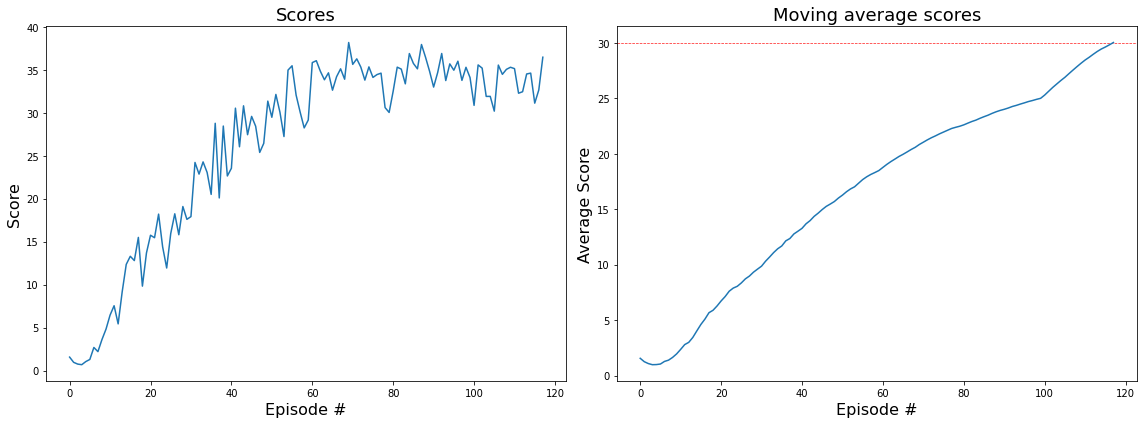

In [9]:
ls = 16
ts = 18

# plot the scores and moving average
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(np.arange(len(scores)), scores)
ax1.set_ylabel('Score', fontsize=ls)
ax1.set_xlabel('Episode #', fontsize=ls)
ax1.set_title("Scores", fontsize=ts)

ax2.axhline(y=30., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(moving)), moving)
ax2.set_ylabel('Average Score', fontsize=ls)
ax2.set_xlabel('Episode #', fontsize=ls)
ax2.set_title("Moving average scores", fontsize=ts)

fig.savefig('images/ddpg_result.jpg', format='jpg')
fig.tight_layout()

plt.show()

#### 4. Watch the Agent

In [6]:
agent.actor_local.load_state_dict(torch.load('solved_actor.pth'))
agent.critic_local.load_state_dict(torch.load('solved_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]      
states = env_info.vector_observations

while True:
    actions = agent.act(states, add_noise=False)                        
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores + env_info.rewards
    states = next_states
    if np.any(dones):
        break
print(f'Total score (averaged over agents) this episode: {np.mean(scores):.1f}')

Total score (averaged over agents) this episode: 26.3


In [7]:
env.close()